In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary libraries
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

2024-11-25 21:51:36.283571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import pandas as pd
# Define paths
train_dir = 'Train'
metadata_dir = 'Metadata'
classes_to_copy = [f"{i:05d}" for i in range(43)]  # All classes (00000 to 00042)
num_images_per_class = 50  # Limit to 50 images per class
img_size = (224, 224)
def load_images_and_boxes(train_dir, metadata_dir, classes_to_copy, img_size, num_images_per_class):
    images, boxes, labels = [], [], []

    for class_id in classes_to_copy:
        img_count = 0
        # Load metadata
        metadata_file = os.path.join(metadata_dir, f'GT-{class_id}.csv')
        if not os.path.exists(metadata_file):
            continue

        metadata = pd.read_csv(metadata_file, sep=';')

        for idx, row in metadata.iterrows():
            if img_count >= num_images_per_class:
                break
            img_path = os.path.join(train_dir, class_id, row['Filename'])
            if not os.path.exists(img_path):
                continue

            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Original dimensions
            original_height, original_width = img.shape[:2]

            # Resize image to model input size
            img_resized = cv2.resize(img, img_size)
            images.append(img_resized)

            # Scale bounding box (ROI) coordinates to the new image size
            x_scale = img_size[0] / original_width
            y_scale = img_size[1] / original_height
            x1 = int(row['Roi.X1'] * x_scale)
            y1 = int(row['Roi.Y1'] * y_scale)
            x2 = int(row['Roi.X2'] * x_scale)
            y2 = int(row['Roi.Y2'] * y_scale)
            boxes.append([x1, y1, x2, y2])

            # Label
            labels.append(int(row['ClassId']))

            img_count += 1

    images = np.array(images) / 255.0  # Normalize images
    boxes = np.array(boxes)
##    labels = to_categorical(labels, num_classes=len(classes_to_copy))

    labels = np.array(labels)
    print("Labels before to_categorical:", labels.shape)
    labels = to_categorical(labels, num_classes=len(classes_to_copy))
    print("Labels after to_categorical:", labels.shape)


    return images, boxes, labels
# Load images, bounding boxes, and labels
images, boxes, labels = load_images_and_boxes(train_dir, metadata_dir, classes_to_copy, img_size, num_images_per_class)
print(f"Loaded images: {images.shape}, Boxes: {boxes.shape}, Labels: {labels.shape}")


Labels before to_categorical: (2150,)
Labels after to_categorical: (2150, 43)
Loaded images: (2150, 224, 224, 3), Boxes: (2150, 4), Labels: (2150, 43)


In [ ]:

# Load images and bounding boxes
images, boxes, labels = load_images_and_boxes(train_dir, metadata_dir, classes_to_copy, img_size, num_images_per_class)
print(f"Loaded images: {images.shape}, Boxes: {boxes.shape}, Labels: {labels.shape}")

# Split data into training and validation sets
X_train, X_val, y_train, y_val, box_train, box_val = train_test_split(images, labels, boxes, test_size=0.2, random_state=42)


Labels before to_categorical: (2150,)
Labels after to_categorical: (2150, 43)
Loaded images: (2150, 224, 224, 3), Boxes: (2150, 4), Labels: (2150, 43)


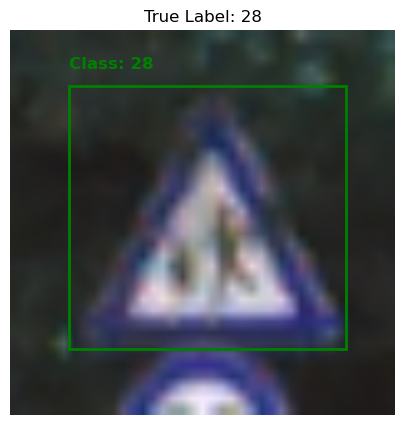

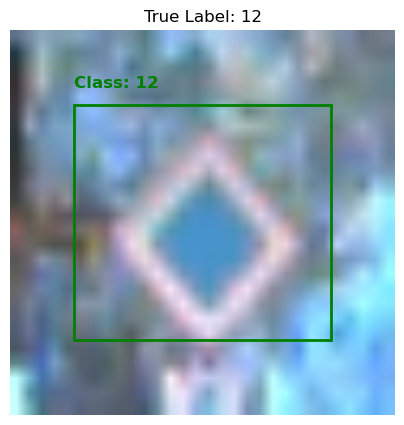

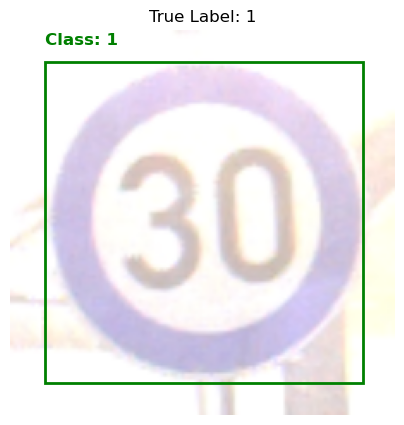

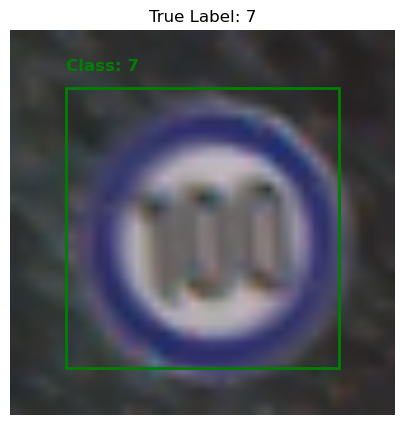

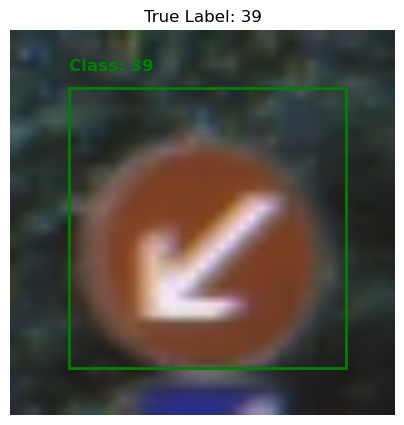

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_true_boxes(images, labels, boxes, num_images=5):
    """
    Visualizes the true bounding boxes of a few images.

    Args:
    - images: Array of image data.
    - labels: Array of class labels for each image.
    - boxes: Array of bounding boxes for each image.
    - num_images: Number of images to visualize.
    """
    for i in range(min(num_images, len(images))):
        # Get image, label, and box for this sample
        image = images[i]
        label = np.argmax(labels[i])  # Convert one-hot encoding to integer label
        box = boxes[i]

        # Convert the image to uint8 format for display if necessary
        image_np = (image * 255).astype(np.uint8) if image.max() <= 1 else image

        plt.figure(figsize=(5, 5))
        plt.imshow(image_np)

        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none'))
        plt.text(x1, y1 - 10, f"Class: {label}", color='green', fontsize=12, fontweight='bold')

        plt.title(f"True Label: {label}")
        plt.axis('off')
        plt.show()

visualize_true_boxes(X_train, y_train, box_train, num_images=5)


In [ ]:
'''
hyperparameter tuning
'''
!pip install keras-tuner


In [ ]:
import keras_tuner as kt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    input_shape = (224, 224, 3)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)

    # Tune the number of neurons in the dense layers
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    class_output = Dense(dense_units, activation='relu')(x)

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    class_output = Dropout(dropout_rate)(class_output)
    class_output = Dense(num_classes, activation='softmax', name='class_output')(class_output)

    # Detection head for bounding boxes
    box_output = Dense(dense_units, activation='relu')(x)
    box_output = Dense(4, activation='linear', name='box_output')(box_output)

    # Define the model
    model = Model(inputs=base_model.input, outputs=[class_output, box_output])

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=['categorical_crossentropy', 'mse'],  # Losses assigned in order to outputs
    metrics=['accuracy', 'mse']  # Metrics assigned in order to outputs
    )
    return model


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into tuning, training, and validation sets
X_tune, X_rest, y_tune, y_rest, box_tune, box_rest = train_test_split(
    images, labels, boxes, test_size=0.8, random_state=42
)

# Further split the remaining data into training and validation sets
X_train, X_val, y_train, y_val, box_train, box_val = train_test_split(
    X_rest, y_rest, box_rest, test_size=0.25, random_state=42
)

# Manually split the tuning data
X_tune_train, X_tune_val, y_tune_train, y_tune_val, box_tune_train, box_tune_val = train_test_split(
    X_tune, y_tune, box_tune, test_size=0.2, random_state=42
)

# Verify the shapes
print("y_tune_train shape:", y_tune_train.shape)  # Should be (344, 43)
print("y_tune_val shape:", y_tune_val.shape)      # Should be (86, 43)


y_tune_train shape: (344, 43)
y_tune_val shape: (86, 43)


In [ ]:
num_classes=len(classes_to_copy)
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_class_output_accuracy", direction="max"),  # Specify the objective with direction
    max_trials=10,  # Number of hyperparameter configurations to try
    executions_per_trial=1,  # Number of models to train per configuration (averages results)
    directory='hyperparam_tuning',
    project_name='traffic_sign_detection'
)


Reloading Tuner from hyperparam_tuning/traffic_sign_detection/tuner0.json


In [ ]:
y_tune = y_tune.reshape(-1, y_tune.shape[-1])  # Reshape to (samples, 43)
y_train = y_train.reshape(-1, y_train.shape[-1])  # Reshape to (samples, 43)
y_val = y_val.reshape(-1, y_val.shape[-1])  # Reshape to (samples, 43)

print("Shape of y_tune:", y_tune.shape)  # Should be (samples, 43)
# Apply similar checks for y_train and y_val
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)


Shape of y_tune: (430, 43)
Shape of y_train: (1290, 43)
Shape of y_val: (430, 43)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Run hyperparameter search on the tuning set
tuner.search(
    X_tune_train, [y_tune_train, box_tune_train],
    validation_data=(X_tune_val, [y_tune_val, box_tune_val]),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping]
)


### from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Run hyperparameter search on the tuning set
tuner.search(X_tune, {'class_output': y_tune, 'box_output': box_tune},
             validation_split=0.2,  # Use a split within the tuning set
             epochs=5,  # Limit epochs for faster tuning
             batch_size=16,
             callbacks=[early_stopping])


In [ ]:
# Retrieve the best model and hyperparameters
num_classes = len(classes_to_copy)  # Ensure this is set to 43 classes

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)


Best Hyperparameters:
{'dense_units': 128, 'dropout': 0.2, 'learning_rate': 0.001}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Print the output names of the best model
print("Model Output Names:", best_model.output_names)


Model Output Names: ListWrapper(['class_output', 'box_output'])


In [ ]:
# Load images, bounding boxes, and labels
images, boxes, labels = load_images_and_boxes(train_dir, metadata_dir, classes_to_copy, img_size, num_images_per_class)
X_tune, X_rest, y_tune, y_rest, box_tune, box_rest = train_test_split(
    images, labels, boxes, test_size=0.8, random_state=42
)

# Further split the remaining data into training and validation sets
X_train, X_val, y_train, y_val, box_train, box_val = train_test_split(
    X_rest, y_rest, box_rest, test_size=0.25, random_state=42
)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)  # Should be (samples, 43)
print("Shape of box_train:", box_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)  # Should be (samples, 43)
print("Shape of box_val:", box_val.shape)


Labels before to_categorical: (2150,)
Labels after to_categorical: (2150, 43)
Shape of X_train: (1290, 224, 224, 3)
Shape of y_train: (1290, 43)
Shape of box_train: (1290, 4)
Shape of X_val: (430, 224, 224, 3)
Shape of y_val: (430, 43)
Shape of box_val: (430, 4)


In [ ]:
# Assuming outputs are in order [class_output, box_output]
history = best_model.fit(
    X_train, [y_train, box_train],
    validation_data=(X_val, [y_val, box_val]),
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 416ms/step - box_output_loss: 13962.1123 - box_output_mse: 13963.0195 - class_output_accuracy: 0.6813 - class_output_loss: 1.3274 - loss: 13964.3457 - val_box_output_loss: 917.1840 - val_box_output_mse: 918.0152 - val_class_output_accuracy: 0.9349 - val_class_output_loss: 0.3588 - val_loss: 918.3746
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 411ms/step - box_output_loss: 634.1031 - box_output_mse: 634.0869 - class_output_accuracy: 0.9229 - class_output_loss: 0.3742 - loss: 634.4611 - val_box_output_loss: 419.7408 - val_box_output_mse: 420.4300 - val_class_output_accuracy: 0.9837 - val_class_output_loss: 0.1590 - val_loss: 420.5892
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 402ms/step - box_output_loss: 373.7309 - box_output_mse: 373.7429 - class_output_accuracy: 0.9707 - class_output_loss: 0.1734 - loss: 373.9163 - val_box_output_loss: 305.8841 - val_box_output_mse: 306.1379 - val_class_output_accuracy: 0.9837 - val_class_output_loss: 0.1104 - va

In [ ]:
# Save the trained model to Google Drive
model_save_path = 'traffic_sign_classifier_mobilenetv2.h5'
best_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to traffic_sign_classifier_mobilenetv2.h5


In [ ]:
import os

# List all files in the directory
drive_dir = '/content/drive/MyDrive/'
files = os.listdir(drive_dir)
print("Files in Google Drive directory:", files)


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model without compiling
loaded_model = load_model(model_save_path, compile=False)

# Recompile the model with the required loss functions, metrics, and optimizer
loaded_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=['categorical_crossentropy', 'mse'],  # Losses assigned in order to outputs
    metrics=['accuracy', 'mse']  # Metrics assigned in order to outputs
)

print("Model loaded and recompiled successfully.")

Model loaded and recompiled successfully.


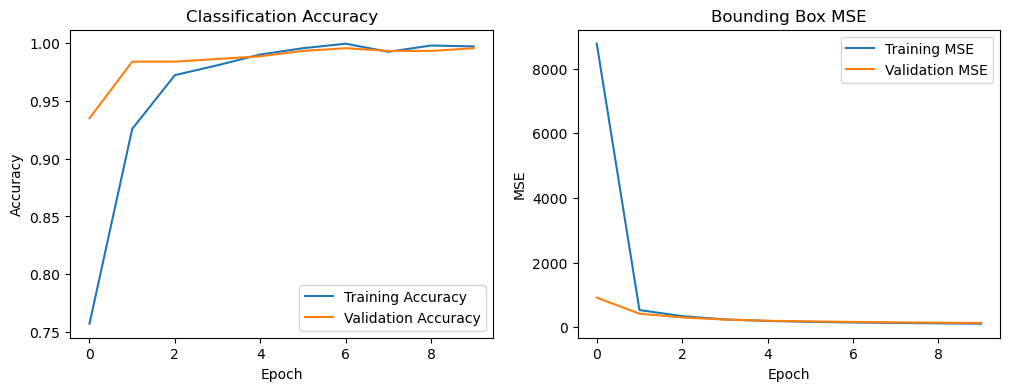

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 541ms/step


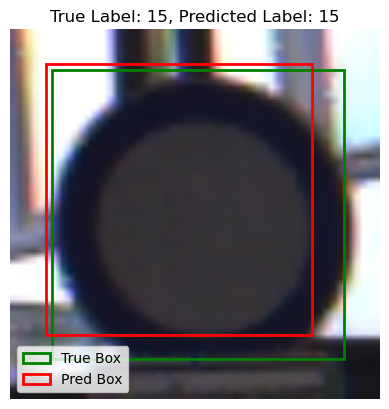

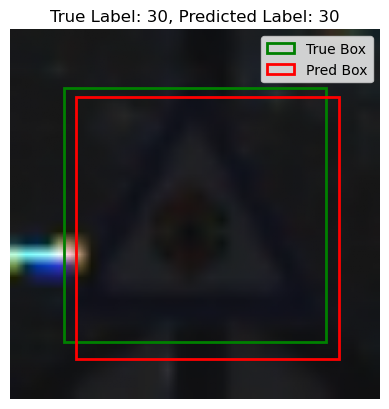

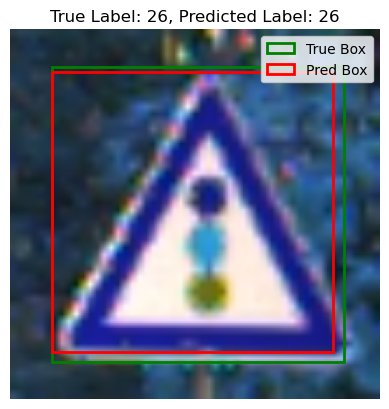

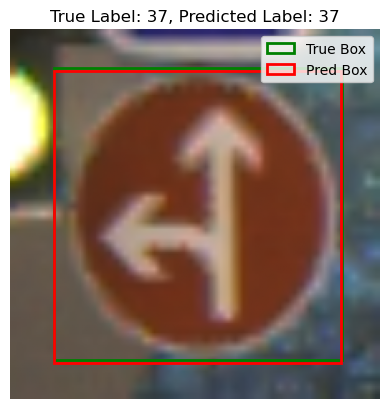

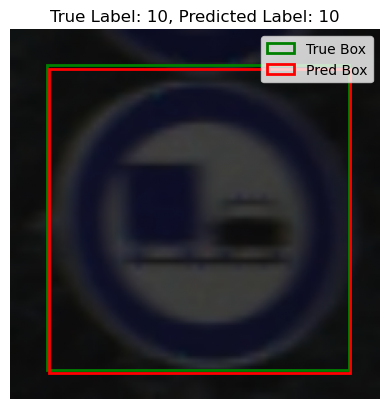

In [ ]:
# Step 5: Evaluate model performance and visualize results
# Plot training history for both classification and bounding box detection
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Classification accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Bounding box loss (MSE)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['box_output_mse'], label='Training MSE')
    plt.plot(history.history['val_box_output_mse'], label='Validation MSE')
    plt.title('Bounding Box MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.show()

plot_history(history)

# Step 6: Visualize predictions with bounding boxes
def visualize_predictions(model, images, boxes, labels):
    predictions = model.predict(images)
    class_preds, box_preds = predictions[0], predictions[1]

    for i in range(5):  # Show 5 random samples
        img = images[i]
        true_box = boxes[i]
        pred_box = box_preds[i]
        label = np.argmax(labels[i])
        pred_label = np.argmax(class_preds[i])

        plt.imshow(img)
        plt.title(f"True Label: {label}, Predicted Label: {pred_label}")

        # Draw true bounding box
        plt.gca().add_patch(Rectangle((true_box[0], true_box[1]),
                                      true_box[2] - true_box[0],
                                      true_box[3] - true_box[1],
                                      linewidth=2, edgecolor='g', facecolor='none', label="True Box"))

        # Draw predicted bounding box
        plt.gca().add_patch(Rectangle((pred_box[0], pred_box[1]),
                                      pred_box[2] - pred_box[0],
                                      pred_box[3] - pred_box[1],
                                      linewidth=2, edgecolor='r', facecolor='none', label="Pred Box"))

        plt.legend(["True Box", "Pred Box"])
        plt.axis('off')
        plt.show()

visualize_predictions(best_model, X_val, box_val, y_val)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) for two bounding boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0

def evaluate_model_performance(model, X_val, y_val, box_val, iou_threshold=0.5):
    """
    Evaluates the performance of the model on both classification and recognition tasks.

    Args:
    - model: Trained model to evaluate.
    - X_val: Validation images.
    - y_val: Validation labels (one-hot encoded).
    - box_val: Validation bounding boxes.

    Prints accuracy, precision, recall, F1-score for classification, MSE and IoU for bounding boxes.
    """
    # Get predictions
    predictions = model.predict(X_val)
    class_preds, box_preds = predictions[0], predictions[1]

    # Convert one-hot encoded labels back to integer labels
    y_true_labels = np.argmax(y_val, axis=1)
    y_pred_labels = np.argmax(class_preds, axis=1)

    # Calculate classification metrics
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    print("Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Calculate Mean Squared Error (MSE) for bounding box predictions
    mse_box = np.mean(np.square(box_val - box_preds))
    print("\nBounding Box Detection Metrics:")
    print(f"Mean Squared Error (MSE) for bounding boxes: {mse_box:.4f}")

    # Calculate IoU for each bounding box and compute average IoU
    iou_scores = [calculate_iou(box_val[i], box_preds[i]) for i in range(len(box_val))]
    avg_iou = np.mean(iou_scores)
    iou_above_threshold = np.mean([1 if iou >= iou_threshold else 0 for iou in iou_scores])

    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Proportion of boxes with IoU >= {iou_threshold}: {iou_above_threshold:.4f}")

# Call the evaluation function
evaluate_model_performance(best_model, X_val, y_val, box_val, iou_threshold=0.5)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step
Classification Metrics:
Accuracy: 0.9953
Precision: 0.9958
Recall: 0.9953
F1 Score: 0.9954

Bounding Box Detection Metrics:
Mean Squared Error (MSE) for bounding boxes: 134.0380
Average IoU: 0.8312
Proportion of boxes with IoU >= 0.5: 0.9930


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the trained model with custom objects
model_path = 'traffic_sign_classifier_mobilenetv2.h5'
model = load_model(
    model_path,
    custom_objects={
        'mse': MeanSquaredError(),
        'MeanSquaredError': MeanSquaredError()
    }
)
print("Model loaded successfully.")

# Number of classes (adjust this to match your model)

num_classes = 43  # Adjust as necessary
class_names = {
    0: 'Speed Limit 20 km/h',
    1: 'Speed Limit 30 km/h',
    2: 'Speed Limit 50 km/h',
    3: 'Speed Limit 60 km/h',
    4: 'Speed Limit 70 km/h',
    5: 'Speed Limit 80 km/h',
    6: 'End of Speed Limit 80 km/h',
    7: 'Speed Limit 100 km/h',
    8: 'Speed Limit 120 km/h',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 tons'
}


# Initialize video capture
video_capture = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not video_capture.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define the expected input size for your model
img_size = (224, 224)  # Adjust if your model expects a different size

def preprocess_frame(frame):
    # Convert BGR to RGB if necessary
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Resize the frame to the input size of the model
    frame_resized = cv2.resize(frame_rgb, img_size)
    # Normalize pixel values to [0, 1]
    frame_normalized = frame_resized / 255.0
    # Expand dimensions to match the model's input shape
    frame_input = np.expand_dims(frame_normalized, axis=0)
    return frame_input

confidence_threshold = 0.5  # Adjust as necessary

while True:
    ret, frame = video_capture.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Preprocess the frame
    frame_input = preprocess_frame(frame)

    # Get predictions from the model
    class_pred, box_pred = model.predict(frame_input)

    # Process the outputs
    class_id = np.argmax(class_pred[0])
    class_confidence = np.max(class_pred[0])

    # Print predictions for debugging
    print(f"Predicted Class ID: {class_id}, Confidence: {class_confidence}")
    print(f"Class Probabilities: {class_pred[0]}")
    print(f"Bounding Box Prediction: {box_pred[0]}")

    # Apply confidence threshold
    if class_confidence > confidence_threshold:
        # Bounding box output
        x1, y1, x2, y2 = box_pred[0]

        # Scale bounding box coordinates back to original frame size
        original_height, original_width = frame.shape[:2]
        x_scale = original_width / img_size[0]
        y_scale = original_height / img_size[1]

        x1 = int(x1 * x_scale)
        y1 = int(y1 * y_scale)
        x2 = int(x2 * x_scale)
        y2 = int(y2 * y_scale)

        # Ensure coordinates are within frame bounds
        x1 = max(0, min(x1, original_width - 1))
        y1 = max(0, min(y1, original_height - 1))
        x2 = max(0, min(x2, original_width - 1))
        y2 = max(0, min(y2, original_height - 1))

        # Draw bounding box on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Prepare label text
        label_text = f"{class_names.get(class_id, 'Unknown')}: {class_confidence*100:.1f}%"

        # Put label text above the bounding box
        cv2.putText(frame, label_text, (x1, max(0, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    else:
        # Optionally, display that no confident detection was made
        cv2.putText(frame, "No confident detection", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

    # Display the resulting frame
    cv2.imshow('Real-Time Traffic Sign Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
video_capture.release()
cv2.destroyAllWindows()
